In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pandas as pd
import numpy as np
from data_operations import (
    load_data,
    EMG_CHANNELS,
    EMG_HP_CHANNELS,
    GYRO_CHANNELS,
    ACC_CHANNELS,
    IMU_CHANNELS,
    augment_data,
)
import scipy.stats
import itertools
from feature_extraction import (
    FeatureExtractor,
    process_dataframe,
    zero_crossings,
    mean_crossings,
    peak_frequency,
    spectral_entropy,
)
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dataset = load_data()
dataset

Trimming observations to 967 samples


time_ms       ch0       ch1  ch0_hp  ch1_hp  \
body_label rep sample_num                                                    
0          1   0.0         1514824.503  12535249  12566283  -11889   17295   
               1.0         1514827.496  12536264  12559246   -2063   13384   
               2.0         1514830.493  12538584  12565279    2757   16008   
               3.0         1514833.500  12546745  12567024    7504    5644   
               4.0         1514836.498  12537375  12545467   -3855  -15893   
...                                ...       ...       ...     ...     ...   
4          3   962.0       1618110.457  12136089  12370189  -31898   45780   
               963.0       1618113.448  12165574  12340495   20709    2953   
               964.0       1618116.437  12200077  12301532   45799  -36427   
               965.0       1618119.442  12153545  12317293  -14411   -3002   
               966.0       1618122.435  12099585  12324114  -50651   13979   

                                 qx        qy        qz        qw          gx  \
body_label rep sample_num                                                       
0          1   0.0         0.321960 -0.596619 -0.621826  0.392090   -1.342870   
               1.0         0.321960 -0.596741 -0.621826  0.392029   -1.510729   
               2.0         0.321960 -0.596741 -0.621765  0.391968   -1.230964   
               3.0         0.321960 -0.596741 -0.621765  0.391968   -1.230964   
               4.0         0.321960 -0.596802 -0.621765  0.391907   -1.063105   
...                             ...       ...       ...       ...         ...   
4          3   962.0      -0.749451 -0.095520 -0.654175  0.034607 -167.187300   
               963.0      -0.749451 -0.095520 -0.654175  0.034607 -167.187300   
               964.0      -0.725403 -0.101318 -0.679504  0.041626 -168.474210   
               965.0      -0.725403 -0.101318 -0.679504  0.041626 -168.474210   
               966.0      -0.698059 -0.106567 -0.706360  0.049316 -169.984940   

                                   gy         gz         ax         az  \
body_label rep sample_num                                                
0          1   0.0           1.063105   0.503576  -0.660156 -10.003906   
               1.0           1.175011   0.000000  -0.660156 -10.003906   
               2.0           1.175011  -0.279765  -0.660156 -10.003906   
               3.0           1.175011  -0.279765  -0.660156 -10.003906   
               4.0           0.839294  -0.727388  -0.660156 -10.003906   
...                               ...        ...        ...        ...   
4          3   962.0      -729.625900 -75.424520 -15.074219  -1.500000   
               963.0      -729.625900 -75.424520 -15.074219  -1.500000   
               964.0      -807.568360 -64.513700 -15.074219  -1.500000   
               965.0      -807.568360 -64.513700 -15.074219  -1.500000   
               966.0      -887.133360 -53.043358 -15.074219  -1.500000   

                                 ay  emg_raw  emg_hp  
body_label rep sample_num                             
0          1   0.0          1.21875    31034   29184  
               1.0          1.21875    22982   15447  
               2.0          1.21875    26695   13251  
               3.0          1.21875    20279   -1860  
               4.0          1.21875     8092  -12038  
...                             ...      ...     ...  
4          3   962.0      -11.37500   234100   77678  
               963.0      -11.37500   174921  -17756  
               964.0      -11.37500   101455  -82226  
               965.0      -11.37500   163748   11409  
               966.0      -11.37500   224529   64630  

[14505 rows x 17 columns]

In [7]:
extractors = {}

# EMG Features
extractors.update(
    {
        "emg_raw": [
            FeatureExtractor("min_max", lambda x: np.max(x) - np.min(x)),
            FeatureExtractor("rms", lambda x: np.sqrt(np.sum(x ** 2))),
            FeatureExtractor("mean_xing", mean_crossings),
        ],
        "emg_hp": [
            FeatureExtractor("absmax", lambda x: np.max(np.abs(x)), segment_length=300),
            FeatureExtractor("rms", lambda x: np.sqrt(np.sum(x ** 2))),
            FeatureExtractor("peak_f", peak_frequency),
            FeatureExtractor("spec_entropy", spectral_entropy(256, int(256 * 0.8))),
        ],
    }
)

# Dynamics Features

extractors.update(
    {
        channel: [
            FeatureExtractor("rms", lambda x: np.sqrt(np.sum(x ** 2))),
            FeatureExtractor("var", np.var),
            FeatureExtractor("pk-pk", lambda x: (np.max(x) - np.min(x))),
        ]
        for channel in GYRO_CHANNELS
    }
)

# Mixed channel features
extractors.update(
    {
        q_pair: [FeatureExtractor("corr", lambda x: np.corrcoef(x.T)[0, 1])]
        for q_pair in itertools.combinations(IMU_CHANNELS, 2)
    }
)
extractors.update(
    {
        q_pair: [FeatureExtractor("corr", lambda x: np.corrcoef(x.T)[0, 1])]
        for q_pair in itertools.combinations(GYRO_CHANNELS, 2)
    }
)
extractors.update(
    {
        q_pair: [FeatureExtractor("corr", lambda x: np.corrcoef(x.T)[0, 1])]
        for q_pair in itertools.combinations(ACC_CHANNELS, 2)
    }
)

results = process_dataframe(dataset, extractors)
results

emg_raw.min_max  emg_raw.rms  emg_raw.mean_xing  \
body_label rep                                                    
0.0        1.0        -1.167758    -1.087015          -0.206472   
           2.0         0.248565     0.659467          -1.091353   
           3.0         1.467714     1.255982           0.316412   
1.0        1.0        -1.097477    -1.065849           1.885065   
           2.0        -0.860929    -0.725752          -0.488025   
           3.0         1.351613     1.773152           1.241515   
2.0        1.0        -1.117667    -1.126200           1.241515   
           2.0        -0.442040    -0.494840          -1.051132   
           3.0         1.500976     1.292990          -0.890244   
3.0        1.0        -0.740936    -0.713983          -0.246694   
           2.0        -0.422480    -0.527136          -0.648913   
           3.0         0.939583     1.002620          -0.648913   
4.0        1.0        -0.772720    -0.894652           1.482846   
           2.0         0.308828     0.392099          -0.890244   
           3.0         0.804729     0.259117          -0.005363   

                emg_hp.absmax.0.300  emg_hp.absmax.300.600  \
body_label rep                                               
0.0        1.0            -0.550452              -0.549185   
           2.0            -0.552295              -0.431995   
           3.0            -0.422393               0.368347   
1.0        1.0            -0.390561              -0.528986   
           2.0            -0.587159              -0.525959   
           3.0             1.715279               0.640446   
2.0        1.0            -0.407096              -0.521907   
           2.0            -0.667757              -0.596167   
           3.0             0.858850               0.226511   
3.0        1.0            -0.468260              -0.268553   
           2.0            -0.591897              -0.517085   
           3.0            -0.017240              -0.000072   
4.0        1.0            -0.091801              -0.231398   
           2.0            -0.569811              -0.406468   
           3.0             2.742592               3.342469   

                emg_hp.absmax.600.900  emg_hp.rms  emg_hp.peak_f  \
body_label rep                                                     
0.0        1.0              -0.690335   -0.644400       0.398549   
           2.0              -0.741720   -0.659878       0.398549   
           3.0               1.958134    1.011411      -1.071994   
1.0        1.0              -0.551533   -0.579108       1.846923   
           2.0              -0.735179   -0.698381       0.398549   
           3.0               1.885003    1.399710      -1.101552   
2.0        1.0              -0.759777   -0.659993       0.391159   
           2.0              -0.844174   -0.827022       0.391159   
           3.0               0.955052    0.670685      -1.071994   
3.0        1.0              -0.504552   -0.451314       0.398549   
           2.0              -0.809045   -0.712841       0.398549   
           3.0               0.501829    0.210261      -1.094163   
4.0        1.0              -0.458911   -0.331487       1.684350   
           2.0              -0.254829   -0.334700      -1.049825   
           3.0               1.050036    2.607058      -0.916811   

                emg_hp.spec_entropy    gx.rms  ...  ('qx', 'qw').corr  \
body_label rep                                 ...                      
0.0        1.0             0.750544 -0.814012  ...           0.564739   
           2.0             0.389636  1.105525  ...          -1.136483   
           3.0            -1.774153 -0.782012  ...           1.151648   
1.0        1.0             0.823204 -0.784482  ...          -0.949917   
           2.0             0.782419  1.276856  ...          -1.146213   
           3.0            -1.717629 -0.614520  ...           1.156584   
2.0        1.0             0.832356 -1.024606  ...          -0.923054   
       

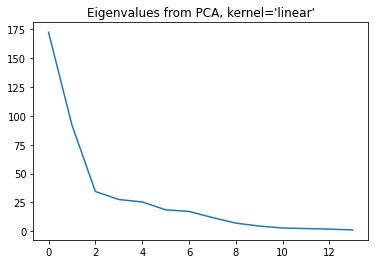

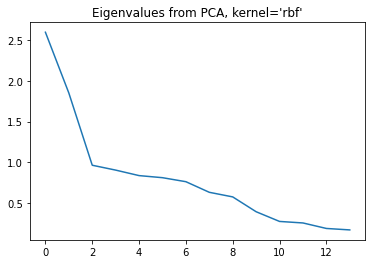

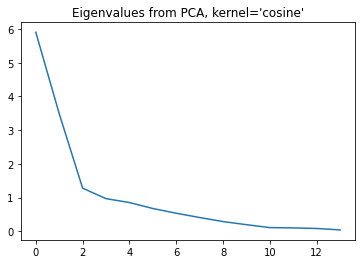

In [8]:
%matplotlib inline

pca_outputs = {}
for kernel in ['linear', 'rbf', 'cosine']:
    pca = KernelPCA(kernel=kernel)
    pca.fit(results)
    plt.figure()
    plt.plot(pca.eigenvalues_)
    plt.title(f'Eigenvalues from PCA, {kernel=}')
    pca_outputs[kernel] = pd.DataFrame(data=pca.transform(results), index=results.index)



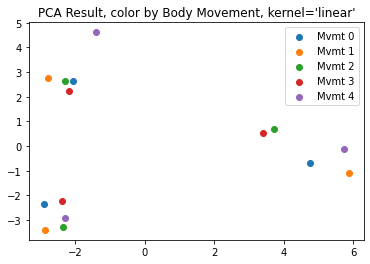

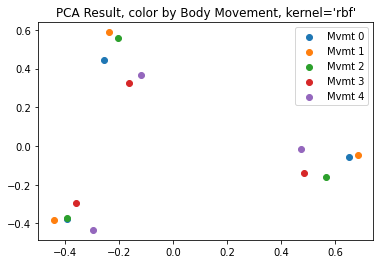

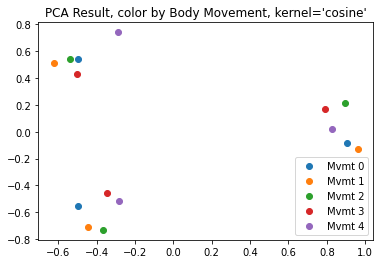

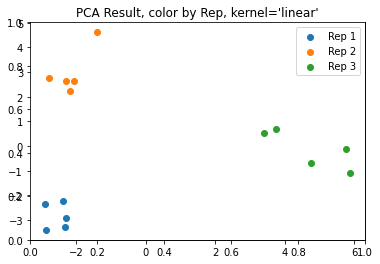

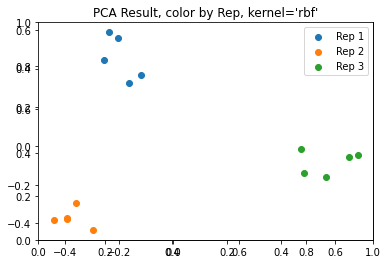

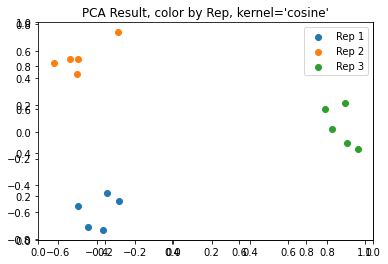

In [16]:
# Color clusters by body for each kernel
for kernel, frame in pca_outputs.items():
    plt.figure()
    plt.title(f"PCA Result, color by Body Movement, {kernel=}")
    for body, subframe in frame.groupby(level=0):
        plt.scatter(
            subframe.values[:, 0], subframe.values[:, 1], label=f"Mvmt {int(body)}"
        )
    plt.legend()
    plt.show()

# Color clusters by rep for each kernel
for kernel, frame in pca_outputs.items():
    plt.figure()
    plt.title(f"PCA Result, color by Rep, {kernel=}")
    ax = plt.axes()
    for rep, subframe in frame.groupby(level=1):
        plt.scatter(
            subframe.values[:, 0], subframe.values[:, 1], label=f"Rep {int(rep)}"
        )
    plt.legend()
    plt.show()

## Combined Clustering Results

Combining features extracted for EMG data and dynamics data have made clusters more distinct, especially for PCA using the `cosine` kernel.  3 distinct clusters have formed independent of body movement, similar to both the independent EMG and dynamics studies.

Class labels are simply the repetition number.

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

for name, classifier in zip(["LDA", "SVM"], [LinearDiscriminantAnalysis, SVC]):
    for kernel, frame in pca_outputs.items():
        # Grab 2 dimensions of data
        x = frame.loc[:, :1].values
        y = np.array([0, 1, 2] * 5)
        k_fold_selection = KFold(n_splits=2)
        for train_idx, test_idx in k_fold_selection.split(x):
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            lda = classifier()
            lda.fit(x_train, y_train)
            y_pred = lda.predict(x_test)
            print(f"Classification Result for {name}, PCA kernel = {kernel}")
            print(classification_report(y_test, y_pred))

Classification Result for LDA, PCA kernel = linear
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Classification Result for LDA, PCA kernel = linear
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

Classification Result for LDA, PCA kernel = rbf
              precision    recall  f1-score   support

           0       1.00      1.00